# Backtester

In [47]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('lib/predictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
from stockPredictor import StockPredictor 

## Config


In [48]:
np.set_printoptions(threshold=50, edgeitems=20)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from IPython.display import HTML

In [49]:
index='Timestamp'
# index='time_period_start'
sample_size=60000
PATH='data/stock/'

In [50]:
# # train.to_csv(f'{PATH}test.csv', sep=',', encoding='utf-8')

# p = StockPredictor(pd.DataFrame(), index)
# p.read_from_feather(PATH)
# p.train

## Create datasets

In [51]:
table_names = [
#         'btc-bitstamp-2012-01-01_to_2018-01-08'
#     'BTC_COINBASE_2018-07-25_09-06'
#     'ETH_COINBASE_07-21_08-24'
#     'COINBASE_BCH_2018-06-15_09-01'
#     'COINBASE_BTC_2017-11-01_01-09'
    'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27'
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11',
#     'bitstamp_07-09'
#     'btc_historical_parsed'
]

In [52]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [53]:
# for t in tables: display(t.head())

In [54]:
train= tables[0]
train

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000


In [55]:
p = StockPredictor(train, index)
p.sample_train(sample_size)
# p.train = p.train.head(100000)
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
p.train

Train size: 60000 Original size: 3405857


,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
3345857,1526457660,26.550062,8225.76,8231.10,8214.96,8219.41,8227.973854
3345858,1526457720,34.885183,8211.04,8224.59,8211.04,8223.22,8220.233172
3345859,1526457780,9.264438,8223.20,8223.22,8209.95,8220.48,8219.315640
3345860,1526457840,0.492657,8218.20,8220.19,8206.74,8210.00,8209.759134
3345861,1526457900,3.316244,8210.01,8211.47,8200.00,8200.00,8205.694099
3345862,1526457960,16.905971,8200.00,8211.99,8200.00,8211.99,8203.406465
3345863,1526458020,7.328694,8214.90,8217.42,8210.00,8210.19,8210.371585
3345864,1526458080,18.336561,8210.00,8228.10,8210.00,8228.10,8212.709133
3345865,1526458140,26.440258,8228.10,8229.00,8215.84,8215.84,8228.900159
3345866,1526458200,3.018970,8215.81,8234.00,8215.81,8234.00,8227.560670


## Change Point Analysis Setup

In [56]:
# ! pip install ruptures
import ruptures as rpt
import matplotlib.pyplot as plt

In [57]:
signal_df = pd.DataFrame({
    'Close':p.train.Close,
    'Volume':p.train.Volume
})[['Close','Volume']]
signal = signal_df.values

#### Binary Segmentation

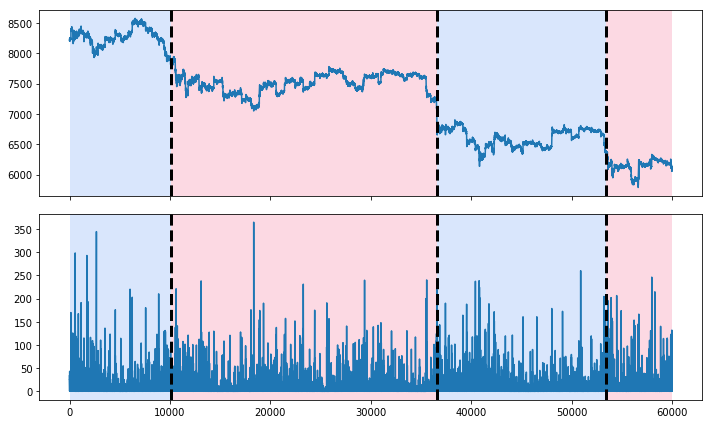

In [58]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()

In [59]:
my_bkps

[10060, 36565, 53395, 60000]

#### Window Based

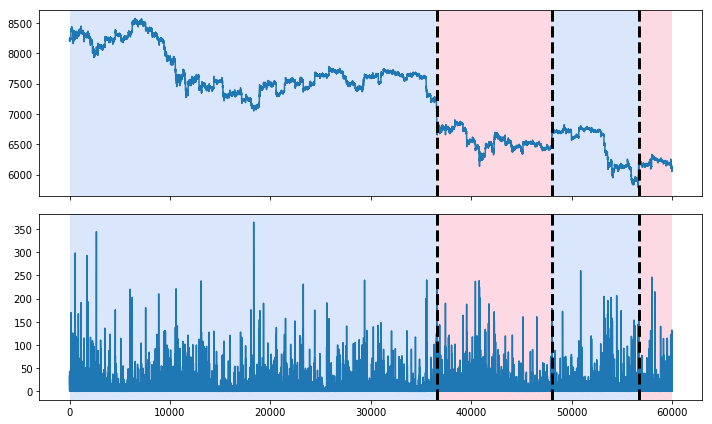

In [60]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=40, model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()

In [61]:
my_bkps

[36575, 48025, 56680, 60000]